Setup

In [121]:
import pandas as pd
file_name = "measurment_2channels_much_runs.csv"
time_ramp = 100000000.0 # 100 ms
time_rise = time_ramp * 0.5
time_fall = time_ramp * 0.5
v_max = 3.200
v_min = 0

used functions

In [122]:
def get_voltage(counts):
    time = counts * 4
    if (time <= time_rise):
        #print("cal time rise")
        #print(v_max/ time_rise)
        return (v_max/ time_rise) * time
    elif (time <= time_rise + time_fall):
        #print("cal time fall")
        return (v_max - ((v_max - v_min) / time_fall) * (time - time_rise))
def get_diff(df_voltage):
    mean = df_voltage.mean()
    mean_ch1_high = mean["Ch1_high_voltage"]
    mean_ch1_low = mean["Ch1_low_voltage"]
    mean_ch2_high = mean["Ch2_high_voltage"]
    mean_ch2_low = mean["Ch2_low_voltage"]
    diff_high_ch1 = df_voltage["Ch1_high_voltage"].map(lambda x : mean_ch1_high - x)
    diff_low_ch1 = df_voltage["Ch1_low_voltage"].map(lambda x : mean_ch1_low - x)
    diff_high_ch2 = df_voltage["Ch2_high_voltage"].map(lambda x : mean_ch2_high - x)
    diff_low_ch2 = df_voltage["Ch2_low_voltage"].map(lambda x : mean_ch2_low - x)
    df_diff_mean = pd.concat([diff_high_ch1,diff_low_ch1,diff_high_ch2,diff_low_ch2], axis=1)
    df_diff_mean = df_diff_mean.rename(columns={"Ch2_low_voltage":"Ch2_low_diff_mean","Ch2_high_voltage":"Ch2_high_diff_mean","Ch1_low_voltage":"Ch1_low_diff_mean","Ch1_high_voltage":"Ch1_high_mean"})
    return df_diff_mean

def read_csv():
    df = pd.read_csv(file_name)
    df_voltage = df.map(get_voltage)
    df_voltage = df_voltage.rename(columns={"Ch1 high Counts":"Ch1_high_voltage","Ch1 low Counts":"Ch1_low_voltage","Ch2 high counts":"Ch2_high_voltage","Ch2 low counts":"Ch2_low_voltage"})
    mean_voltage = df_voltage.mean()
    min_voltage = df_voltage.min()
    max_voltage = df_voltage.max()
    #print(mean_voltage)
    #print(min_voltage)
    #print(max_voltage)
    #print(df_voltage["Ch1_high_voltage"])
    return df_voltage

start stuff

In [123]:
df_voltage = read_csv()
df_diff_mean = get_diff(df_voltage)
df_prozessed = pd.concat([df_voltage,df_diff_mean], axis=1)
output_file = file_name.split(".")[0] + "_voltage." + file_name.split(".")[1]
df_prozessed.to_csv(output_file)
mean_voltage = df_prozessed.mean()
min_voltage = df_prozessed.min()
max_voltage = df_prozessed.max()
print("min Voltage")
print(min_voltage)
print("Max Voltage")
print(max_voltage)
print("mean Voltage")
print(mean_voltage)

min Voltage
Ch1_high_voltage      0.000000
Ch1_low_voltage       0.000000
Ch2_high_voltage      0.000000
Ch2_low_voltage       0.000000
Ch1_high_mean        -0.003645
Ch1_low_diff_mean    -0.074016
Ch2_high_diff_mean   -0.003612
Ch2_low_diff_mean    -0.009115
dtype: float64
Max Voltage
Ch1_high_voltage      1.385046
Ch1_low_voltage       1.323705
Ch2_high_voltage      1.373416
Ch2_low_voltage       1.240882
Ch1_high_mean         1.381400
Ch1_low_diff_mean     1.249689
Ch2_high_diff_mean    1.369804
Ch2_low_diff_mean     1.231767
dtype: float64
mean Voltage
Ch1_high_voltage      1.381400e+00
Ch1_low_voltage       1.249689e+00
Ch2_high_voltage      1.369804e+00
Ch2_low_voltage       1.231767e+00
Ch1_high_mean         9.434082e-17
Ch1_low_diff_mean     1.060373e-16
Ch2_high_diff_mean    1.173492e-16
Ch2_low_diff_mean     7.658782e-17
dtype: float64


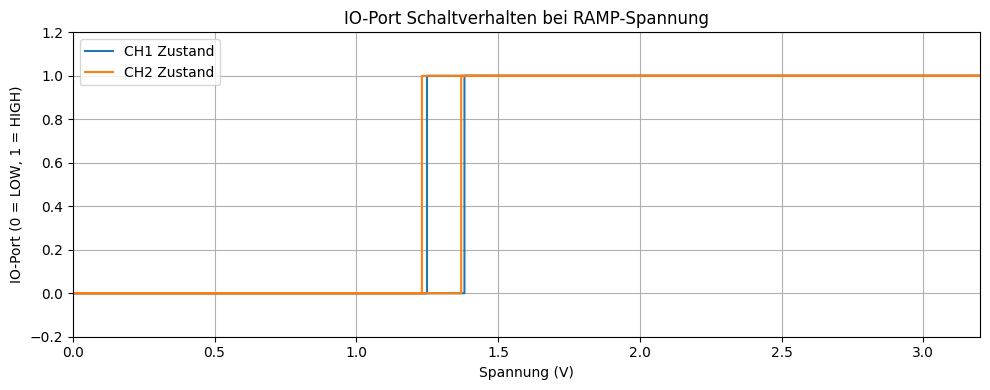

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameter ---
v_max = 3.2                  # Maximale RAMP-Spannung
samples = 10000                # Anzahl Schritte pro Ramp-Richtung
threshold_high_ch1 =mean_voltage["Ch1_high_voltage"]        # Schwelle zum Einschalten (steigend)
threshold_low_ch1 = mean_voltage["Ch1_low_voltage"]         # Schwelle zum Ausschalten (fallend)
threshold_high_ch2 =mean_voltage["Ch2_high_voltage"]        # Schwelle zum Einschalten (steigend)
threshold_low_ch2 = mean_voltage["Ch2_low_voltage"]
# --- RAMP erzeugen ---
ramp_up = np.linspace(0, v_max, samples)
ramp_down = np.linspace(v_max, 0, samples)
voltage_ramp = np.concatenate([ramp_up, ramp_down])

# --- IO-Port Zustand berechnen ---
io_state_ch1 = []
io_state_ch2 = []
state = 0  # Start mit LOW (0)

for v in voltage_ramp:
    if state == 0 and v >= threshold_high_ch1:
        state = 1
    elif state == 1 and v <= threshold_low_ch1:
        state = 0
    io_state_ch1.append(state)
for v in voltage_ramp:
    if state == 0 and v >= threshold_high_ch2:
        state = 1
    elif state == 1 and v <= threshold_low_ch2:
        state = 0
    io_state_ch2.append(state)


# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(voltage_ramp, io_state_ch1, drawstyle='steps-post', label="CH1 Zustand")
plt.plot(voltage_ramp, io_state_ch2, drawstyle='steps-post', label="CH2 Zustand")
plt.xlabel("Spannung (V)")
plt.ylabel("IO-Port (0 = LOW, 1 = HIGH)")
plt.title("IO-Port Schaltverhalten bei RAMP-Spannung")
plt.ylim(-0.2, 1.2)
plt.xlim(0, v_max)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
